# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import tensorflow as tf
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
import cv2
import random
from sklearn.model_selection import train_test_split

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = str(X_train.shape[1]) + "x" + str(X_train.shape[2]) + "x" + str(X_train.shape[3])

output = set()
for x in y_train:
    output.add(x)

# TODO: how many classes are in the dataset
n_classes = len(output)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32x32x3
Number of classes = 43


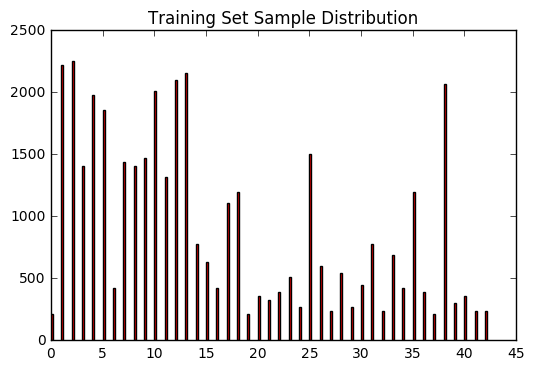

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import csv

def findsignnames(filename):
    signnames = []
    with open(filename, 'rt') as csvfile:
        signnamereader = csv.reader(csvfile)
        for row in signnamereader:
            signnames.append(row[1])
    signnames = signnames[1:]
    return signnames

'''For future use , extracting signnames'''
signnames = findsignnames('signnames.csv')

def displaysignnames(signnames):
    i=0
    for signname in signnames:
        print(str(i)+":"+signname)
        i+=1

class_set = np.zeros(n_classes)
for label in y_train:
    class_set[label] = class_set[label]+1


ind = np.arange(n_classes)
width = 0.2
fig, ax = plt.subplots()
ax.set_title('Training Set Sample Distribution')
rects1 = ax.bar(ind, class_set, width, color='r')

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Sample Image


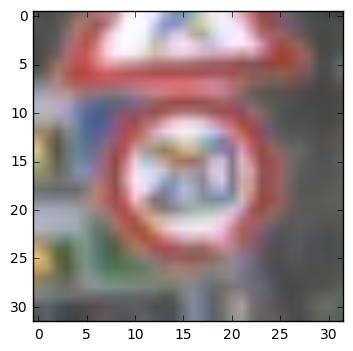

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print("Sample Image")
plt.imshow(X_train[0])
plt.show()

#print("Before normalization")
#print(X_train[0])

###Divide the image by 255 to normalize it between 0 and 1 

X_train = X_train/255.
X_test =  X_test/255.

#print("After normalization")
#print(X_train[0])

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** <ul>
<li>The data we are using from the pickle files are already resized for us in 32x32x3 size.
That makes our job easier.</li>
<li>Also, color is an important factor when considering traffic signs.Hence I dont think it is a good idea to convert the images to grayscale.</li>
<li>Therefore the only steps required for the preprocessing is to normalize the data.</li> 
<li>To normalize the data, we simply divide the training and the test data by 255.</li>
</ul>

In [10]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

y_train_original = train['labels']
x_train_original = train['features']


def generate_y_data_map(y_train_original):
    i=0
    y_map = {}
    for y_data in y_train_original:
        if y_map.get(y_data)==None:
            y_map[y_data]={i}
        else:
            y_map[y_data].add(i)
        i+=1
    return y_map

y_map = generate_y_data_map(y_train_original)

mean = int(len(y_train_original)/43)


#Using this function from Udacity forum @ 
#https://carnd-udacity.atlassian.net/wiki/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img


X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05,
    random_state=832289)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** We use the sklearn.model_selection's train_test_split function to split the training data randomly into the training and the validation data. The validation data size is 5% of the training data. 

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
    #layer = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    #layer = tf.nn.relu(layer, name=None)
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


learning_rate = 1e-4
training_epochs = 10
batch_size = 100
display_step = 10

n_input = 3072  #  data input (img shape: 32*32*3)
n_classes = 43  # total classes (43)

# input data is of type 32*32*3
x = tf.placeholder("float", [None, 32, 32, 3])

### Layer 1 ###

W_conv1 = weight_variable([5, 5, 3, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Layer 2 ###
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

###Fully connected Layer 3 ###

W_fc1 = weight_variable([8 * 8 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

##Drop out layer###

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 43])
b_fc2 = bias_variable([43])

### Classifier ###
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), 
                                              reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


####Training data, validation data and test data 
###keeping drop rate of 0.5 for training data, 1.0 for validation and test

train_feed_dict = {x: X_train, y_: y_train, keep_prob: 0.5}
valid_feed_dict = {x: X_valid, y_: y_valid, keep_prob: 1.0}
test_feed_dict = {x: X_test, y_: y_test, keep_prob: 1.0}
saver = tf.train.Saver()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

We use a 2 layer convolution network which is described as under : 

1) The input is first fed into the first convolution layer with a input width and input height of 5x5 , 3 color channels and output into a feature set of 32.<br>
2) This first layer is passed through a max_pooling layer of 2x2.<br>
3) The output of the first layer is passed through a second convolution layer with a input width and input height of 5x5 and 32 features to output a feature set of 64.<br>
4) This second layer is again passed through a max_pooling layer of 2x2.<br>
5) The output of the second layer is then passed through a fully connected layer that outputs features of size 1024.<br>
6) Before the fully connected layer is passed on to the classifier, we pass it through a dropout layer to remove any overfitting.<br>
7) The output of this is fed into a classifier that classifies the data into one of the 43 classes.<br>


In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.

with tf.Session() as session:
    session.run(tf.initialize_all_variables())

    batch_count = int(math.ceil(len(X_train)/batch_size))
    
    for epoch_i in range(1000):
        # Get a batch of training features and labels
        for batch_i in range(100):
            batch_start = batch_i*batch_size
            batch_features = X_train[batch_start:batch_start + batch_size]
            batch_labels = y_train[batch_start:batch_start + batch_size]
            train_step.run(feed_dict={x: batch_features, y_: batch_labels, keep_prob: 0.5})

        if epoch_i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict=valid_feed_dict)
            batch_accuracy = accuracy.eval(feed_dict={x: batch_features, 
                                                          y_: batch_labels, 
                                                          keep_prob: 0.5})
            print("Epoch %d, training accuracy %g, batch accuracy %g "%(epoch_i, train_accuracy,batch_accuracy))                
            print("test accuracy %g"%accuracy.eval(feed_dict=test_feed_dict))
        
            save_path = saver.save(session, "model.ckpt")
    
    print("Model saved in file: %s" % save_path)
    print("test accuracy %g"%accuracy.eval(feed_dict=test_feed_dict))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

1) Optimizer : We use adam optimizer instead of the gradient descent optimizer simply because adam uses moving averages of the parameters (momentum), so we do not have to worry about fine tuning the hyperparameters.Adam to use a larger effective step size, and the algorithm will converge to this step size without fine tuning.
(Reference : http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow)<br>

2) We have used a batch size of 100 and epoch size of 1000. I could have used more epochs but training this model takes a long time on my machine which unfortunately does not have a CUDA compatible GPU. At the same time, I was unable to get an Amazon P2xlarge instance which would have been perfect for training this model.<br>

3) We have used a drop out rate of 0.5 for the training , but 1.0 i.e no dropout for the validation and the test data<br>

4) I have saved this model and have reused it for the rest of the project below


In [27]:
def testmodel(model,test_feed,calculate_acc=False,debug=False):
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Later, launch the model, use the saver to restore variables from disk, and
    # do some work with the model.
    cls_pred = np.zeros(shape=X_test.shape, dtype=np.float32)
    y_conv_result = np.zeros(shape=y_test.shape,dtype=np.float32)
    top_five_result = np.zeros(shape=(len(y_test)),dtype=np.float32)
    prediction=tf.argmax(y_conv,1)
    cls_correct = tf.argmax(y_,1)
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, model)
        if debug:
            print("Model restored.")
        if calculate_acc:
            print("test accuracy %g"%accuracy.eval(feed_dict=test_feed_dict))        
        y_conv_result = y_conv.eval(feed_dict=test_feed)
        labels = tf.argmax(y_, 1)
        top_five = tf.nn.in_top_k(y_conv_result, labels, 5)
        top_five_result = top_five.eval(feed_dict=test_feed)
        
        #print(topFiver)
        #print(cls_pred)
        cls_pred = prediction.eval(feed_dict=test_feed)
        #return cls_pred
        return cls_pred,top_five_result,y_conv_result


cls_pred,top_five_result,y_conv_result = testmodel("model_1000_iterations.ckpt",test_feed_dict,calculate_acc=True)
print(cls_pred)

test accuracy 0.936025
[16  1 38 ...,  5  7 10]


In [19]:
from sklearn.metrics import confusion_matrix

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test_original, y_test_original = test['features'], test['labels']

num_classes = 43

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=1.6, wspace=1.6)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: \n{0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correctarray is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    incorrect = (correct == False)
    length = len(cls_pred)
    correctarray = [False]*length
    for i in range(length):
        if cls_pred[i] == correct[i]:
            correctarray[i]=True
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = []
    prediction = []
    true_copy = []
    i = 0 
    for pred in correctarray:
        if pred==False:
            images.append(X_test[i])
            prediction.append(cls_pred[i])
            true_copy.append(correct[i])
        i+=1
    
    # Get the predicted classes for those images.

    # Get the true classes for those images.
    cls_true = correct[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=true_copy[0:9],
                cls_pred=prediction[0:9])
    
def plot_confusion_matrix(pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = y_test
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=y_test_original,
                          y_pred=pred)

    # Print the confusion matrix as text.
    #print(cm)
    

    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    
    # Make various adjustments to the plot.
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

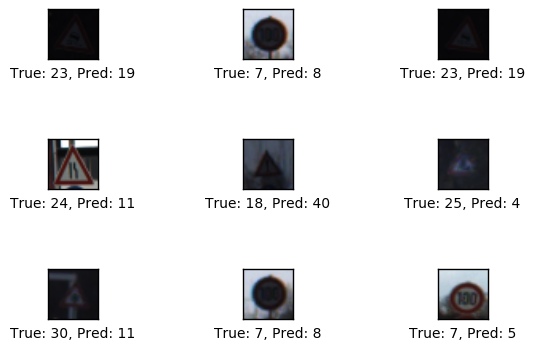

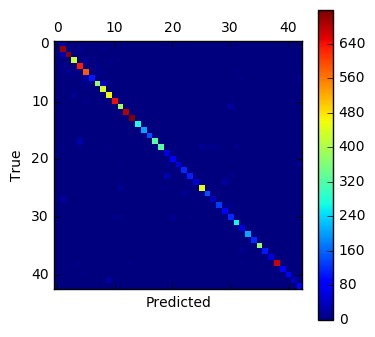

In [20]:
plot_example_errors(cls_pred,y_test_original)
plot_confusion_matrix(cls_pred)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

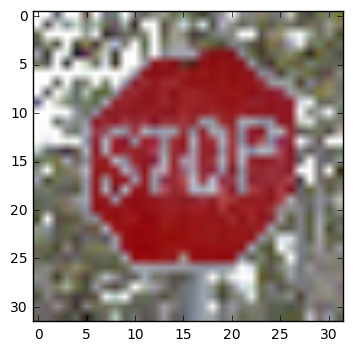

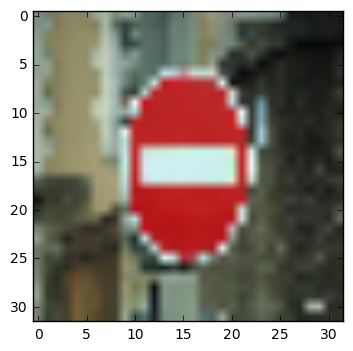

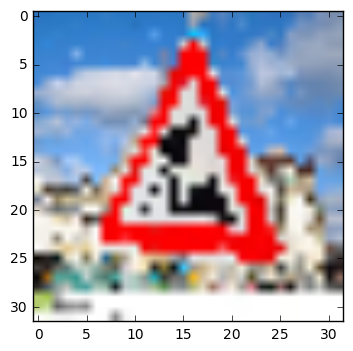

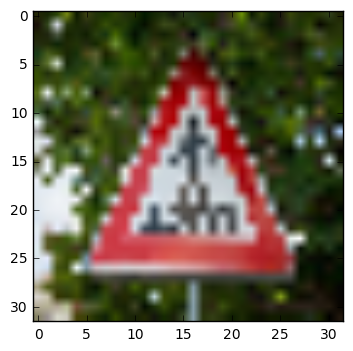

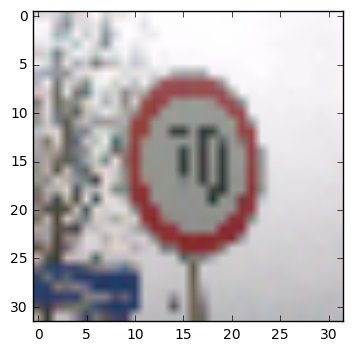

Stop
No entry
Road work
Bumpy road
Speed limit (70km/h)
[ True  True  True  True  True]


In [32]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

data = []
y=[]

def loadimg(filename):
    img = cv2.imread(filename,cv2.IMREAD_UNCHANGED)
    res = cv2.resize(img,(32, 32), interpolation = cv2.INTER_CUBIC)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    plt.imshow(res)
    plt.show()
    data.insert(len(data),res)

loadimg("STOP_sign.jpg")
loadimg("noentry.jpg")
loadimg("roadworksign.jpg")
loadimg("pedestrian2.jpg")
loadimg("70kh.jpg")

data = np.asarray(data)
data = data/255.

y.insert(len(y),14)
y.insert(len(y),17)
y.insert(len(y),25)
y.insert(len(y),27)
y.insert(len(y),4)

y_test = np.asarray(y)

encoder = LabelBinarizer()
encoder.fit(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_test = y_test.astype(np.float32)

test_feed_dict_new_data = {x: data,y_:y_test, keep_prob: 1.0}

result,prob,y_prob = testmodel("model_1000_iterations.ckpt",test_feed_dict_new_data)
for i in result:
    print(signnames[i])

print(prob)

In [38]:
for i in range(len(y)):
    print(y_prob[i][y[i]])
    i+=1

1.0
1.0
0.971174
9.75986e-08
0.882181


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.